In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms as T
from torchvision.transforms import InterpolationMode
from torchvision.datasets import Cityscapes
from PIL import Image
from tqdm import tqdm
from matplotlib import colormaps

from utils import overlay_mask
from decode_heads import SegmentationHead


trainId_to_name = {
     0: 'road',
     1: 'sidewalk',
     2: 'building',
     3: 'wall',
     4: 'fence',
     5: 'pole',
     6: 'traffic light',
     7: 'traffic sign',
     8: 'vegetation',
     9: 'terrain',
    10: 'sky',
    11: 'person',
    12: 'rider',
    13: 'car',
    14: 'truck',
    15: 'bus',
    16: 'train',
    17: 'motorcycle',
    18: 'bicycle',
    19: 'unlabeled'
}

In [2]:
dataset = Cityscapes("cityscapes", target_type="semantic")

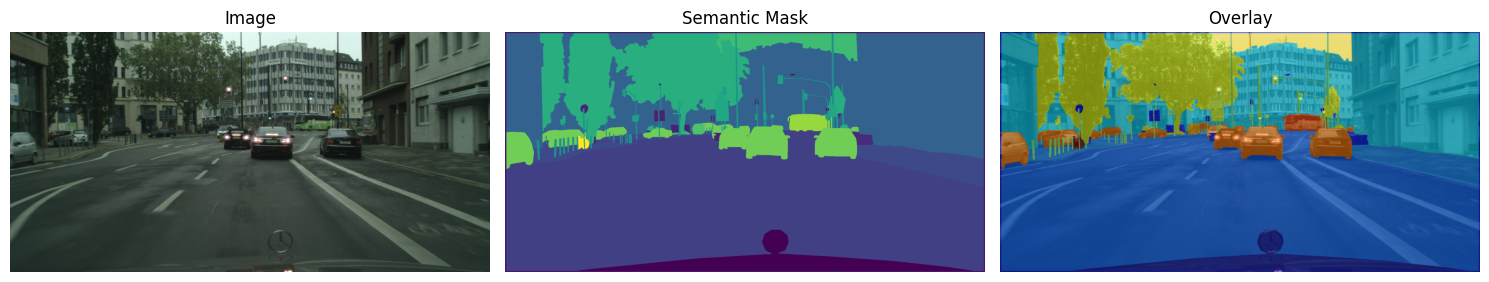

In [3]:
img, mask = dataset[0]
img = img.convert('RGB')

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Semantic Mask")
plt.imshow(mask)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(overlay_mask(img, mask))
plt.axis("off")

plt.tight_layout()
plt.show()

In [17]:
def map_labels_to_trainIds(label_tensor, mapping):
    # Vectorized mapping for efficiency
    out = label_tensor.clone()
    for label_id, train_id in mapping.items():
        out[label_tensor == label_id] = train_id
    return out


def get_class_frequency(label_tensor, num_classes=19, ignore_index=19):
    # Map label IDs to trainIds first
    mapped = map_labels_to_trainIds(label_tensor, CityscapesDataset.label2trainId)
    valid_mask = mapped != ignore_index
    valid_labels = mapped[valid_mask].flatten()
    counts = torch.bincount(valid_labels, minlength=num_classes).float()
    total_valid = counts.sum()
    if total_valid == 0:
        return torch.zeros(num_classes)
    
    return counts / total_valid


class CityscapesDataset(Dataset):
    label2trainId = {
        0: 19, 1: 19, 2: 19, 3: 19, 4: 19, 
        5: 19, 6: 19, 7: 0, 8: 1, 9: 19, 
        10: 19, 11: 2, 12: 3, 13: 4, 14: 19, 
        15: 19, 16: 19, 17: 5, 18: 19, 19: 6,
        20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 
        25: 12, 26: 13, 27: 14, 28: 15, 29: 19,
        30: 19, 31: 16, 32: 17, 33: 18
    }
    
    def __init__(self, root_dir, split='train', image_size=(224, 224), n_class=20):
        """
        root_dir: path to Cityscapes dataset
        split: 'train', 'val', or 'test'
        image_size: (height, width) for resizing
        """
        self.image_dir = os.path.join(root_dir, 'leftImg8bit', split)
        self.label_dir = os.path.join(root_dir, 'gtFine', split)
        self.image_size = image_size
        self.n_class = n_class

        self.embed_trainId = nn.Embedding(num_embeddings=n_class, embedding_dim=1000)

        self.image_paths = []
        self.label_paths = []

        for city in os.listdir(self.image_dir):
            img_dir = os.path.join(self.image_dir, city)
            lbl_dir = os.path.join(self.label_dir, city)

            for fname in os.listdir(img_dir):
                if fname.endswith('_leftImg8bit.png'):
                    img_path = os.path.join(img_dir, fname)
                    lbl_fname = fname.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
                    lbl_path = os.path.join(lbl_dir, lbl_fname)

                    self.image_paths.append(img_path)
                    self.label_paths.append(lbl_path)

        self.image_paths = sorted(self.image_paths)
        self.label_paths = sorted(self.label_paths)
        
        # Transforms
        self.image_transform = T.Compose([
            T.Resize(image_size),
            T.ToTensor(),  ## Converts to [0, 1], shape (3, H, W)
        ])
        self.label_transform = T.Compose([
            T.Resize(image_size, interpolation=Image.NEAREST),
            T.PILToTensor(),                         ## Returns shape (1, H, W), dtype: uint8
            T.Lambda(lambda x: x.squeeze(0).long())  ## Convert to (H, W), dtype: long
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = Image.open(self.label_paths[idx])       ## contains trainIds: 0–18 and 255

        img = self.image_transform(img)                 ## (3, H, W)
        label_tensor = self.label_transform(label)      ## (H, W), dtype: long

        y = self.convert_to_class_embedding(label_tensor)
        
        return img, y

    def convert_to_class_embedding(self, label_tensor: Tensor) -> Tensor:
        # Map label IDs to trainIds
        mapped = map_labels_to_trainIds(label_tensor, CityscapesDataset.label2trainId)
        freqs = get_class_frequency(mapped, num_classes=self.n_class, ignore_index=self.n_class - 1)
        
        # Weighted sum of embeddings
        embeddings = torch.stack([self.embed_trainId(torch.tensor(i)) * freqs[i] for i in range(self.n_class)])
        w_embed = embeddings.sum(dim=0)
        
        return w_embed

dataset = CityscapesDataset(root_dir='cityscapes', split='train')
img, y = dataset[0]

print("Image shape:", img.shape)    ## torch.Size([3, H, W])
print("Label shape:", y.shape)      ## torch.Size([H, W])

Image shape: torch.Size([3, 224, 224])
Label shape: torch.Size([1000])


In [18]:
loader = DataLoader(dataset, 64)

In [20]:
img, y = next(iter(loader))

In [21]:
img.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 1000]))